### Reading model data: the ReadModelData class

This notebook introduces the `ReadModelData` class of Pyaerocom, a flexible interface for importing model results from a single model, based on variable name (e.g. *od550aer*, *od550bc*), start / stop time stamps and temporal resolution (e.g. *hourly, 3hourly, daily, monthly*). 

In the following cells, we create an instance of the the `ReadModelData` class and use this object to find and import data files containing the aerosol optical depth at 550 nm (*od550aer*) from the ECMWF CAMS reanalysis model (*ECMWF_CAMS_REAN*) for the years 2003-2007 in daily resolution. The files will be temporally merged and put into an instance of the `ModelData` class. 

We start with creating a reading object, that will take care of finding the model directory of us (based on the model ID) and all valid NetCDF files on initialisation. The `print` statetment prints the string representation of the `ReadModelData` object, which provides useful information about what is in there.

In [1]:
import pyaerocom
read = pyaerocom.io.ReadModelData(model_id="ECMWF_CAMS_REAN",
                                  start_time="1-1-2003",
                                  stop_time="31.12.2007", 
                                  verbose=True)
print(read)

Searching dir for ID ECMWF_CAMS_REAN in: /lustre/storeA/project/aerocom/aerocom-users-database/ECMWF/
Found: /lustre/storeA/project/aerocom/aerocom-users-database/ECMWF/ECMWF_CAMS_REAN

Failed to import file od550aer.29feb2004.nc
Error: OSError('Failed to extract year information from file od550aer.29feb2004.nc using file convention aerocom2',)
Failed to import file od550aer.29feb2007.nc
Error: OSError('Failed to extract year information from file od550aer.29feb2007.nc using file convention aerocom2',)

Pyaerocom ReadModelData
-----------------------
Model ID: ECMWF_CAMS_REAN
Available variables: ['ang4487aer', 'od440aer', 'od550aer', 'od550bc', 'od550dust', 'od550oa', 'od550so4', 'od550ss', 'od865aer']
Available years: [2003, 2004, 2005, 2006, 2007, 9999]


Looking at the output we can see that there were some files that did not follow the Aerocom file naming conventions. These were automatically ignored. 

Note that at this point, no data is actually imported but only the paths are set that contain data for this model. In order to read one variable, call the ``read_var`` function with a valid variable name. You can check available variables using the ``vars`` attribute (or by printing the string representation, as shown in the cell above).

In [2]:
print("Detected variables for model %s:\n %s" %(read.model_id, read.vars))

Detected variables for model ECMWF_CAMS_REAN:
 ['ang4487aer', 'od440aer', 'od550aer', 'od550bc', 'od550dust', 'od550oa', 'od550so4', 'od550ss', 'od865aer']


In [3]:
data = read.read_var(var_name="od550aer", ts_type="daily")

FOUND MATCH: ECMWF_CAMS_REAN.daily.od550aer.2003.nc
FOUND MATCH: ECMWF_CAMS_REAN.daily.od550aer.2004.nc
FOUND MATCH: ECMWF_CAMS_REAN.daily.od550aer.2005.nc
FOUND MATCH: ECMWF_CAMS_REAN.daily.od550aer.2006.nc
FOUND MATCH: ECMWF_CAMS_REAN.daily.od550aer.2007.nc
Invalid time dimension.
Error message: AttributeError('Cube does not contain time dimension',)
Invalid time axis in file ECMWF_CAMS_REAN.daily.od550aer.2003.nc. Attempting to correct.
Invalid time dimension.
Error message: AttributeError('Cube does not contain time dimension',)
Invalid time axis in file ECMWF_CAMS_REAN.daily.od550aer.2004.nc. Attempting to correct.
Invalid time dimension.
Error message: AttributeError('Cube does not contain time dimension',)
Invalid time axis in file ECMWF_CAMS_REAN.daily.od550aer.2005.nc. Attempting to correct.
Invalid time dimension.
Error message: AttributeError('Cube does not contain time dimension',)
Invalid time axis in file ECMWF_CAMS_REAN.daily.od550aer.2006.nc. Attempting to correct.
Inva

From the output we can see that based on our specified time range and temporal resolution, we got 6 netCDF files that were merged all into an instance of the `pyaerocom.ModelData` class, which will be introduced in more detail later. 

Now that we have actual data imported, we can print again to see if everything worked as expected.

In [4]:
print(read)


Pyaerocom ReadModelData
-----------------------
Model ID: ECMWF_CAMS_REAN
Available variables: ['ang4487aer', 'od440aer', 'od550aer', 'od550bc', 'od550dust', 'od550oa', 'od550so4', 'od550ss', 'od865aer']
Available years: [2003, 2004, 2005, 2006, 2007, 9999]

Loaded ModelData objects:

Pyaerocom ModelData
-------------------
Variable: od550aer
Temporal resolution: daily
Start / Stop: 2003-01-01T00:00:00.000000 - 2007-12-31T00:00:00.000000


In [5]:
print("\nThe data object is of type %s and contains %d time stamps" %(type(data), data.shape[0]))


The data object is of type <class 'pyaerocom.modeldata.ModelData'> and contains 1826 time stamps


The returned data object is of type `ModelData` (introduced in later tutorials) which contains 1826 time stamps. Given that the defined period of 5 years includes one leap year, we should expect that we imported data for each day of the five years?

In [6]:
print(1826 == 5*365+1)

True


#### Remark on time definition

As you can see in the output above 

``Error message: AttributeError('Cube does not contain time dimension',) 
Invalid time axis in file ECMWF_CAMS_REAN.daily.od550aer.2007.nc. Attempting to correct.``

these data has some issue with the time dimension, in this case, the time variable is not properly defined in the NetCDF file. Pyaerocom can correct for this on data import by 

1. First checking if the time dimension in the NetCDF file is correct according to CF convention ([see here for details on the implementation](http://aerocom.met.no/pyaerocom/api.html#pyaerocom.io.helpers.check_time_coord) and if a problem is detected, then ...
2. the time axis is redefined based on the year and time resolution (*ts_type*) that is encrypted in the filename. The latter requires that the file follows one of the [Pyaerocom file conventions](http://aerocom.met.no/pyaerocom/config_files.html#file-conventions).


#### A very brief introduction into the ModelData class

Now as a final step, we briefly introduce some of the features of the `ModelData` class by computing 1. plotting an overview map of the data and plotting a time series of the global weighted average aerosol optical density as well as the same time series at the coordinates in the city of Leipzig, Germany.

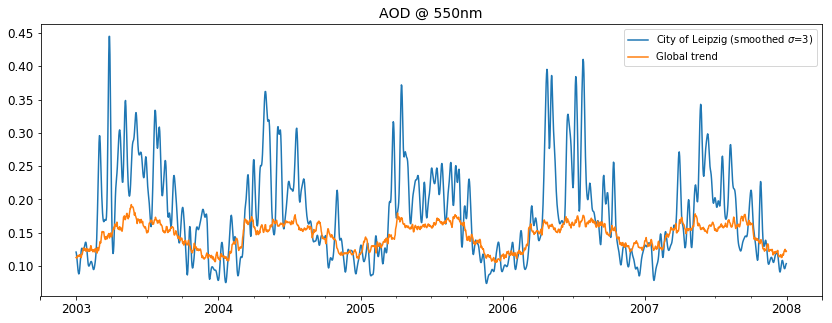

In [7]:
from pandas import Series
from scipy.ndimage import gaussian_filter1d
#compute global mean (area weighted)
glob_mean = data.area_weighted_mean()

#extract AODs at the position of Leipzig
lon_leipzig = 12.44
lat_leipzig = 51.35

data_leipzig = data.interpolate([("latitude", lat_leipzig), 
                                 ("longitude", lon_leipzig)])

# create pandas Series for global average
s_glob = Series(glob_mean, index=data.time_stamps())

# create pandas Series for leipzig average (and smooth in time)
GAUSS_SIGMA = 3
s_leipzig = Series(gaussian_filter1d(data_leipzig.grid.data, GAUSS_SIGMA), 
                   data_leipzig.time_stamps())

ax = s_leipzig.plot(label=r"City of Leipzig (smoothed $\sigma$=%d)" %GAUSS_SIGMA, figsize=(14,5))
s_glob.plot(label="Global trend", ax=ax)
ax.legend()
tit = ax.set_title("AOD @ 550nm")

In the following section, the `ReadMultiModelData` class is introduced, which is largely based on the `ReadModelData` class and allows for importing data from multiple models.